In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from qec_util.performance import plots, confidence_interval_binomial
from qec_util.samplers import read_failures_from_file
from surface_sim.models import SI1000NoiseModel
from lomatching import MoMatching

In [2]:
import matplotlib
import matplotlib.ticker as ticker

matplotlib.rcParams.update(
    {
        "font.size": 11,
        "font.family": "cmr10",
        "font.weight": "normal",
        'axes.unicode_minus': False,
        "axes.formatter.use_mathtext": True,
        "text.usetex": True,
        "axes.formatter.limits": (0,0),
    }
)

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

int_to_alph = {i: s for i, s in enumerate("abcdefghijklmnopqrstuvwxyz")}

In [3]:
# INPUTS
FILE_NAME = "20250130_cliffords_modulo_paulis_and_swap.txt"
DISTANCES = [3, 5, 7]
PROBS = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.008, 0.01, 0.02]
NOISE_MODEL = SI1000NoiseModel
BASES = ["Z", "X"]
FRAMES = ["pre-gate"]
DECODER = MoMatching

PLOTS_DIR = pathlib.Path("plots")

In [4]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir()

In [5]:
# GENERATE CIRCUIT
with open(FILE_NAME, "r") as file:
    data = file.read()
circuits = [block.split("TOTAL CIRCUIT:\n")[1] for block in data.split("\n----------\n") if block != ""]
EXPERIMENTS = list(range(len(circuits)))

NUM_FAILURES = np.load("num-failures_SI1000.npy")
NUM_SAMPLES = np.load("num-samples_SI1000.npy")

LOG_PROB = NUM_FAILURES / NUM_SAMPLES
LOG_PROB_LOWER, LOG_PROB_UPPER = confidence_interval_binomial(NUM_FAILURES, NUM_SAMPLES)

In [6]:
FULL_LOG_PROB = []
FULL_LOG_PROB_LOWER, FULL_LOG_PROB_UPPER = [], []
done = []
for i, _ in enumerate(EXPERIMENTS):
    FULL_LOG_PROB.append(LOG_PROB[i])
    FULL_LOG_PROB_LOWER.append(LOG_PROB_LOWER[i])
    FULL_LOG_PROB_UPPER.append(LOG_PROB_UPPER[i])
    done.append(i)
FULL_LOG_PROB = np.array(FULL_LOG_PROB)
FULL_LOG_PROB_LOWER = np.array(FULL_LOG_PROB_LOWER)
FULL_LOG_PROB_UPPER = np.array(FULL_LOG_PROB_UPPER)
print("shape:", FULL_LOG_PROB.shape)

shape: (360, 2, 1, 3, 16)


In [7]:
assert len(set(range(len(EXPERIMENTS))).difference(done)) == 0
assert (NUM_SAMPLES != 0).all()

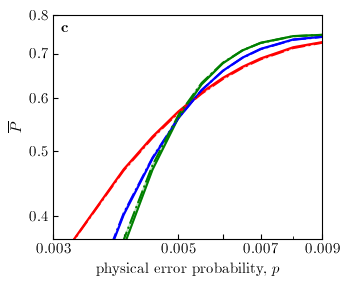

In [8]:
fig, ax = plt.subplots(figsize=cm2inch(8.6, 7))

num_circuits = FULL_LOG_PROB.shape[0]

color_distances_frame = [["red", "blue", "green", "purple"], ["orange", "deepskyblue", "limegreen", "blueviolet"]]
for k, frame in enumerate(FRAMES):
    color_distances = color_distances_frame[k]
    marker_basis = ["s", "*"]
    for j, basis in enumerate(BASES):
        for l, distance in enumerate(DISTANCES):
            ax.plot(PROBS, np.average(FULL_LOG_PROB[:,j,k,l], axis=0), "-" if basis == "Z" else "-.", color=color_distances[l])
            ax.fill_between(PROBS, np.average(FULL_LOG_PROB_LOWER[:,j,k,l], axis=0), np.average(FULL_LOG_PROB_UPPER[:,j,k,l], axis=0), color=color_distances[l], alpha=0.2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("physical error probability, $p$")
ax.set_ylabel("$\\overline{P}$")
ax.set_ylim(3.7e-1, 0.8)
ax.set_xlim(3e-3, 9e-3)

xticks =      [0.003, 0.004, 0.005, 0.006, 0.007, 0.009]
xticklabels = [0.003,    "", 0.005,    "", 0.007, 0.009]
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticklabels))

yticks = [0.4, 0.5, 0.6, 0.7, 0.8]
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.tick_params(direction="in", which="major")
ax.tick_params(direction="in", which="minor")

ax.text(0.0031, 0.755, "\\textbf{c}")

fig.tight_layout(pad=0.30)
fig.savefig(PLOTS_DIR / "threshold_plot_2q-cliffords_circ-level-noise_SI1000.pdf", format="pdf")
plt.show()

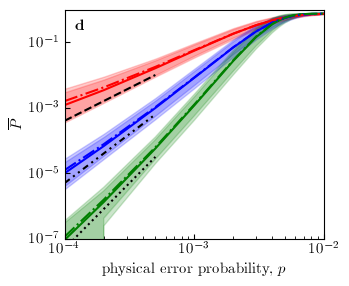

In [9]:
fig, ax = plt.subplots(figsize=cm2inch(8.6, 7))

num_circuits = FULL_LOG_PROB.shape[0]

color_distances_frame = [["red", "blue", "green", "purple"], ["orange", "deepskyblue", "limegreen", "blueviolet"]]
for k, frame in enumerate(FRAMES):
    color_distances = color_distances_frame[k]
    marker_basis = ["s", "*"]
    for j, basis in enumerate(BASES):
        for l, distance in enumerate(DISTANCES):
            ax.plot(PROBS, np.average(FULL_LOG_PROB[:,j,k,l], axis=0), "-" if basis == "Z" else "-.", color=color_distances[l])
            ax.fill_between(PROBS, np.min(FULL_LOG_PROB[:,j,k,l], axis=0), np.max(FULL_LOG_PROB[:,j,k,l], axis=0), color=color_distances[l], alpha=0.2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("physical error probability, $p$")
ax.set_ylabel("$\\overline{P}$")
ax.set_ylim(1e-7, 1.000001)
ax.set_xlim(1e-4, 1e-2)

ax.tick_params(direction="in", which="major")
ax.tick_params(direction="in", which="minor")

ax.text(0.00012, 0.25, "\\textbf{d}")

PROBS_ = np.array(PROBS)
PROBS_ = PROBS_[PROBS_ <1e-3]
ax.plot(PROBS_, PROBS_**2 * 4e4, "--", color="black", label="$\\overline{P} \\propto p^2$")
ax.plot(PROBS_, PROBS_**3 * 5e6, linestyle=(0, (3, 2, 1, 2, 1, 2)), color="black", label="$\\overline{P} \\propto p^3$")
ax.plot(PROBS_, PROBS_**4 * 5e8, ":", color="black", label="$\\overline{P} \\propto p^4$")

fig.tight_layout(pad=0.30)
fig.savefig(PLOTS_DIR / "threshold_plot_2q-cliffords_circ-level-noise_scaling_SI1000.pdf", format="pdf")
plt.show()

# Get best and worse circuits

In [10]:
worse_pl = {d: (0, None) for d in DISTANCES}
second_worse_pl = {d: (0, None) for d in DISTANCES}
best_pl = {d: (np.inf, None) for d in DISTANCES}
second_best_pl = {d: (np.inf, None) for d in DISTANCES}
for i, experiment_name in enumerate(EXPERIMENTS):
    for j, basis in enumerate(BASES):
        for k, frame in enumerate(FRAMES):
            for l, distance in enumerate(DISTANCES):
                for m, prob in enumerate(PROBS):
                    if prob != 5e-4:
                        continue

                    if LOG_PROB[i,j,k,l,m] > worse_pl[distance][0]:
                        worse_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)
                    elif LOG_PROB[i,j,k,l,m] > second_worse_pl[distance][0]:
                        second_worse_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)
                    if LOG_PROB[i,j,k,l,m] < best_pl[distance][0]:
                        best_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)
                    elif LOG_PROB[i,j,k,l,m] < second_best_pl[distance][0]:
                        second_best_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)

In [11]:
print(worse_pl)
print(second_worse_pl)
print(best_pl)
print(second_best_pl)

{3: (0.031554037267080746, 213), 5: (0.0019722943722943723, 248), 7: (0.00012705286839145106, 248)}
{3: (0.03133850931677019, 248), 5: (0.0019011398176291792, 255), 7: (0.0001252313247573911, 255)}
{3: (0.00887989417989418, 0), 5: (0.00044672563209148574, 0), 7: (1.9207414509427932e-05, 0)}
{3: (0.00922967032967033, 2), 5: (0.0004694387084663037, 72), 7: (1.981556597794397e-05, 2)}


In [12]:
for distance in DISTANCES:
    print(distance, worse_pl[distance][0] / best_pl[distance][0])

3 3.553424920144349
5 4.415001581754912
7 6.614782449198842


In [13]:
with open(FILE_NAME, "r") as file:
    data = file.read()
circuits = [block.split("TOTAL CIRCUIT:\n")[1] for block in data.split("\n----------\n") if block != ""]
labelled_circuits_z = {}
labelled_circuits_x = {}
for k, circuit in enumerate(circuits):
    labelled_circuits_z[k] = circuit
    labelled_circuits_x[k] = circuit.replace("R 0 1", "RX 0 1").replace("M 0 1", "MX 0 1")
    
EXPERIMENTS = list(range(len(labelled_circuits_z)))
assert len(EXPERIMENTS) == 360

In [14]:
ind = 248
print("depth =", len(circuits[ind].split("TICK")) - 2)
print(circuits[ind])

depth = 14
R 0 1
TICK
H 0
S 1
TICK
I 0
H 1
TICK
I 0
S 1
TICK
CX 1 0
TICK
H 0
I 1
TICK
CX 0 1
TICK
H 0
I 1
TICK
S 0
I 1
TICK
S 0 1
TICK
I 0
H 1
TICK
I 0
S 1
TICK
CX 1 0
TICK
H 0
I 1
TICK
S 0
I 1
TICK
M 0 1


In [15]:
ind = 255
print("depth =", len(circuits[ind].split("TICK")) - 2)
print(circuits[ind])

depth = 14
R 0 1
TICK
S 0
I 1
TICK
CX 1 0
TICK
H 0
I 1
TICK
CX 0 1
TICK
S 0
I 1
TICK
H 0
I 1
TICK
S 0
I 1
TICK
S 0
I 1
TICK
CX 1 0
TICK
H 0
I 1
TICK
CX 0 1
TICK
S 0
I 1
TICK
H 0
I 1
TICK
S 0
I 1
TICK
M 0 1


In [16]:
ind = 0
print("depth =", len(circuits[ind].split("TICK")) - 2)
print(circuits[ind])

depth = 0
R 0 1
TICK
M 0 1


In [17]:
ind = 2
print("depth =", len(circuits[ind].split("TICK")) - 2)
print(circuits[ind])

depth = 2
R 0 1
TICK
I 0
H 1
TICK
I 0
H 1
TICK
M 0 1
